## 2.6  Entrainement d'un autre agent (agent-supervisé) 
En  utilisant,  cette  fois-ci,  une  autre  approche,  par  exemple celle basée sur l’apprentissage supervisé (p.e un réseau de neurones classique ou profond), dans le même contexte de votre choix pour faire de la classification ou de la prédiction. Vous pouvez utiliser des données réelles ou générer de nouvelles données synthétiques. 

In [1]:
# =============================================================================
# AGENT SUPERVISÉ : Prédiction de Direction de Prix du NASDAQ-100
# =============================================================================
# Objectif : Créer un réseau de neurones qui prédit si le prix va monter (1) 
#            ou descendre (0) dans les prochaines périodes
# =============================================================================

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import time
import warnings
warnings.filterwarnings('ignore')

# Configuration pour la reproductibilité
np.random.seed(42)
torch.manual_seed(42)

print("Bibliothèques importées")
print(f"PyTorch version: {torch.__version__}")
print(f"Device: {'GPU' if torch.cuda.is_available() else 'CPU'}")

Bibliothèques importées
PyTorch version: 2.9.1+cu128
Device: CPU


#### 2.6.1 Chargement et Exploration des Données

In [2]:
# Chargement des données NASDAQ-100
df = pd.read_csv('data/NAS100_m1_2024_2025.csv', sep=';')

# Conversion de la colonne time en datetime
df['time'] = pd.to_datetime(df['time'])
df = df.sort_values('time').reset_index(drop=True)

print("=" * 70)
print(" EXPLORATION DES DONNÉES NASDAQ-100")
print("=" * 70)
print(f"\n Nombre de points de données : {len(df):,}")
print(f" Période : {df['time'].min()} à {df['time'].max()}")
print(f" Prix min : ${df['low'].min():.2f} | Prix max : ${df['high'].max():.2f}")

 EXPLORATION DES DONNÉES NASDAQ-100

 Nombre de points de données : 632,805
 Période : 2024-01-01 23:00:00 à 2025-10-17 22:05:00
 Prix min : $16184.89 | Prix max : $25199.80


In [3]:
df.head()

,time,open,high,low,close,volume
0,2024-01-01 23:00:00,16863.74,16865.54,16858.74,16859.94,-1
1,2024-01-01 23:01:00,16858.94,16859.94,16857.34,16859.64,-1
2,2024-01-01 23:02:00,16859.94,16861.14,16858.94,16859.44,-1
3,2024-01-01 23:03:00,16859.64,16861.84,16859.44,16861.64,-1
4,2024-01-01 23:04:00,16861.84,16861.84,16859.14,16859.34,-1


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 632805 entries, 0 to 632804
Data columns (total 6 columns):
 #   Column  Non-Null Count   Dtype         
---  ------  --------------   -----         
 0   time    632805 non-null  datetime64[ns]
 1   open    632805 non-null  float64       
 2   high    632805 non-null  float64       
 3   low     632805 non-null  float64       
 4   close   632805 non-null  float64       
 5   volume  632805 non-null  int64         
dtypes: datetime64[ns](1), float64(4), int64(1)
memory usage: 29.0 MB


In [5]:
df.describe()

,time,open,high,low,close,volume
count,632805,632805.000000,632805.000000,632805.000000,632805.000000,632805.000000
mean,2024-11-24 11:21:59.636380928,20312.388036,20315.825163,20308.873830,20312.406418,61.198492
min,2024-01-01 23:00:00,16185.190000,16200.190000,16184.890000,16185.390000,-1.000000
25%,2024-06-13 00:06:00,18590.990000,18593.990000,18587.490000,18591.090000,-1.000000
50%,2024-11-22 01:15:00,20084.490000,20087.990000,20080.690000,20084.410000,-1.000000
75%,2025-05-08 05:42:00,21648.390000,21651.730000,21645.190000,21648.370000,94.000000
max,2025-10-17 22:05:00,25197.700000,25199.800000,25190.200000,25197.400000,463.000000
std,NaN,2080.553040,2080.352957,2080.753142,2080.550945,91.990482


#### 2.6.2 Ingénierie des Features et Création de la Variable Cible

In [6]:
# =============================================================================
# CRÉATION DES FEATURES ET CIBLE POUR L'APPRENTISSAGE SUPERVISÉ
# =============================================================================

def calculate_technical_indicators(df):
    """
    Calcule les indicateurs techniques identiques à ceux utilisés dans le DQN
    pour assurer une comparaison équitable
    """
    data = df.copy()
    
    # 1. Moyennes Mobiles Simples (SMA)
    data['SMA_10'] = data['close'].rolling(window=10).mean()
    data['SMA_30'] = data['close'].rolling(window=30).mean()
    
    # 2. Moyenne Mobile Exponentielle (EMA)
    data['EMA_12'] = data['close'].ewm(span=12, adjust=False).mean()
    
    # 3. RSI (Relative Strength Index)
    delta = data['close'].diff()
    gain = (delta.where(delta > 0, 0)).rolling(window=14).mean()
    loss = (-delta.where(delta < 0, 0)).rolling(window=14).mean()
    rs = gain / loss
    data['RSI_14'] = 100 - (100 / (1 + rs))
    
    # 4. MACD (Moving Average Convergence Divergence)
    ema_12 = data['close'].ewm(span=12, adjust=False).mean()
    ema_26 = data['close'].ewm(span=26, adjust=False).mean()
    data['MACD'] = ema_12 - ema_26
    data['MACD_Signal'] = data['MACD'].ewm(span=9, adjust=False).mean()
    data['MACD_Hist'] = data['MACD'] - data['MACD_Signal']
    
    # 5. Bandes de Bollinger
    data['BB_Middle'] = data['close'].rolling(window=20).mean()
    bb_std = data['close'].rolling(window=20).std()
    data['BB_Upper'] = data['BB_Middle'] + (2 * bb_std)
    data['BB_Lower'] = data['BB_Middle'] - (2 * bb_std)
    
    # 6. ATR (Average True Range) - Volatilité
    high_low = data['high'] - data['low']
    high_close = np.abs(data['high'] - data['close'].shift())
    low_close = np.abs(data['low'] - data['close'].shift())
    ranges = pd.concat([high_low, high_close, low_close], axis=1)
    true_range = ranges.max(axis=1)
    data['ATR_14'] = true_range.rolling(window=14).mean()
    
    # 7. Retours (Returns)
    data['returns'] = data['close'].pct_change()
    
    # 8. Volume normalisé
    data['volume_norm'] = data['volume'] / data['volume'].rolling(window=20).mean()
    
    return data

# Calcul des indicateurs
df_features = calculate_technical_indicators(df)

# =============================================================================
# CRÉATION DE LA VARIABLE CIBLE : 3 Classes d'Actions (SELL / HOLD / BUY)
# =============================================================================
# Cette architecture correspond à celle du DQN avec 3 actions possibles
# SELL (0)  : Vendre - quand le prix va baisser de plus de 0.1%
# HOLD (1)  : Ne rien faire - quand le prix reste stable (variation < 0.1%)
# BUY (2)   : Acheter - quand le prix va monter de plus de 0.1%

LOOK_AHEAD = 5  # Prédire l'action optimale dans 5 minutes

# Seuils pour définir les 3 classes
SELL_THRESHOLD = -0.1  # Baisse > 0.1%
BUY_THRESHOLD = 0.1    # Hausse > 0.1%

# Calculer le prix futur et le changement de prix en pourcentage
df_features['future_price'] = df_features['close'].shift(-LOOK_AHEAD)
df_features['price_change_pct'] = ((df_features['future_price'] - df_features['close']) / df_features['close']) * 100

# Fonction pour assigner l'action en fonction du changement de prix
def assign_action(price_change):
    """
    Assigne une action (classe) en fonction du changement de prix futur
    """
    if price_change < SELL_THRESHOLD:
        return 0  # SELL
    elif price_change > BUY_THRESHOLD:
        return 2  # BUY
    else:
        return 1  # HOLD

# Créer la cible à 3 classes
df_features['target'] = df_features['price_change_pct'].apply(assign_action)

# Supprimer les lignes avec NaN
df_clean = df_features.dropna().reset_index(drop=True)

print("=" * 70)
print("FEATURES ENGINEERING COMPLETE")
print("=" * 70)
print(f"\n Nombre de features créées : {len(df_clean.columns) - len(df.columns)}")
print(f" Points de données après nettoyage : {len(df_clean):,}")
print(f"\n Distribution de la cible (Actions de Trading) :")
print(f"   SELL (0) : {(df_clean['target'] == 0).sum():,} samples ({(df_clean['target'] == 0).mean()*100:.2f}%)")
print(f"   HOLD (1) : {(df_clean['target'] == 1).sum():,} samples ({(df_clean['target'] == 1).mean()*100:.2f}%)")
print(f"   BUY (2)  : {(df_clean['target'] == 2).sum():,} samples ({(df_clean['target'] == 2).mean()*100:.2f}%)")
print(f"\n Seuils utilisés :")
print(f"   SELL si changement de prix < {SELL_THRESHOLD}%")
print(f"   HOLD si changement de prix entre {SELL_THRESHOLD}% et {BUY_THRESHOLD}%")
print(f"   BUY si changement de prix > {BUY_THRESHOLD}%")

FEATURES ENGINEERING COMPLETE

 Nombre de features créées : 16
 Points de données après nettoyage : 632,771

 Distribution de la cible (Actions de Trading) :
   SELL (0) : 31,010 samples (4.90%)
   HOLD (1) : 571,988 samples (90.39%)
   BUY (2)  : 29,773 samples (4.71%)

 Seuils utilisés :
   SELL si changement de prix < -0.1%
   HOLD si changement de prix entre -0.1% et 0.1%
   BUY si changement de prix > 0.1%


In [7]:
# Afficher les colonnes créées
print(f"\n Features disponibles :")
feature_cols = [col for col in df_clean.columns if col not in ['time', 'target', 'future_price']]
print(feature_cols)


 Features disponibles :
['open', 'high', 'low', 'close', 'volume', 'SMA_10', 'SMA_30', 'EMA_12', 'RSI_14', 'MACD', 'MACD_Signal', 'MACD_Hist', 'BB_Middle', 'BB_Upper', 'BB_Lower', 'ATR_14', 'returns', 'volume_norm', 'price_change_pct']


### Architecture de Classification à 3 Classes

**Pourquoi 3 classes au lieu de 2 ?**

Notre agent supervisé doit correspondre à l'architecture du DQN décrite dans la section 2.3, qui possède **3 actions possibles** : HOLD, BUY, et SELL. Pour assurer une comparaison équitable, notre réseau de neurones doit également prédire parmi ces 3 classes.

**Définition des classes :**
- **SELL (0)** : Le modèle prédit que le prix va baisser de plus de 0.1% → Action recommandée : Vendre
- **HOLD (1)** : Le modèle prédit que le prix restera stable (variation entre -0.1% et +0.1%) → Action recommandée : Ne rien faire
- **BUY (2)** : Le modèle prédit que le prix va monter de plus de 0.1% → Action recommandée : Acheter

Cette approche permet de modéliser l'incertitude et les petits mouvements de prix où il n'est pas optimal d'agir.

#### 2.6.3 Préparation des Données pour l'Entraînement

In [8]:
# =============================================================================
# PRÉPARATION DES DONNÉES : Train/Val/Test Split
# =============================================================================

# Sélectionner les features pour l'entraînement
feature_columns = ['open', 'high', 'low', 'close', 'volume',
                   'SMA_10', 'SMA_30', 'EMA_12', 'RSI_14',
                   'MACD', 'MACD_Signal', 'MACD_Hist',
                   'BB_Upper', 'BB_Lower', 'ATR_14', 'returns']

X = df_clean[feature_columns].values
y = df_clean['target'].values

# Split temporel : 70% train, 15% validation, 15% test
train_size = int(0.70 * len(X))
val_size = int(0.15 * len(X))

X_train = X[:train_size]
y_train = y[:train_size]

X_val = X[train_size:train_size+val_size]
y_val = y[train_size:train_size+val_size]

X_test = X[train_size+val_size:]
y_test = y[train_size+val_size:]

# Normalisation des features (important pour les réseaux de neurones)
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_val_scaled = scaler.transform(X_val)
X_test_scaled = scaler.transform(X_test)

print("=" * 70)
print(" PRÉPARATION DES DONNÉES")
print("=" * 70)
print(f"\n Nombre de features : {X.shape[1]}")
print(f" Total de points : {len(X):,}")
print(f"\n Split des données :")
print(f"    Train      : {len(X_train):,} samples ({len(X_train)/len(X)*100:.1f}%)")
print(f"    Validation : {len(X_val):,} samples ({len(X_val)/len(X)*100:.1f}%)")
print(f"    Test       : {len(X_test):,} samples ({len(X_test)/len(X)*100:.1f}%)")
print(f"\n Distribution des classes :")
print(f"   Train:")
print(f"      SELL (0): {(y_train == 0).sum():,} ({(y_train == 0).mean()*100:.1f}%)")
print(f"      HOLD (1): {(y_train == 1).sum():,} ({(y_train == 1).mean()*100:.1f}%)")
print(f"      BUY (2) : {(y_train == 2).sum():,} ({(y_train == 2).mean()*100:.1f}%)")
print(f"   Validation:")
print(f"      SELL (0): {(y_val == 0).sum():,} ({(y_val == 0).mean()*100:.1f}%)")
print(f"      HOLD (1): {(y_val == 1).sum():,} ({(y_val == 1).mean()*100:.1f}%)")
print(f"      BUY (2) : {(y_val == 2).sum():,} ({(y_val == 2).mean()*100:.1f}%)")
print(f"   Test:")
print(f"      SELL (0): {(y_test == 0).sum():,} ({(y_test == 0).mean()*100:.1f}%)")
print(f"      HOLD (1): {(y_test == 1).sum():,} ({(y_test == 1).mean()*100:.1f}%)")
print(f"      BUY (2) : {(y_test == 2).sum():,} ({(y_test == 2).mean()*100:.1f}%)")

 PRÉPARATION DES DONNÉES

 Nombre de features : 16
 Total de points : 632,771

 Split des données :
    Train      : 442,939 samples (70.0%)
    Validation : 94,915 samples (15.0%)
    Test       : 94,917 samples (15.0%)

 Distribution des classes :
   Train:
      SELL (0): 21,187 (4.8%)
      HOLD (1): 401,577 (90.7%)
      BUY (2) : 20,175 (4.6%)
   Validation:
      SELL (0): 7,324 (7.7%)
      HOLD (1): 80,351 (84.7%)
      BUY (2) : 7,240 (7.6%)
   Test:
      SELL (0): 2,499 (2.6%)
      HOLD (1): 90,060 (94.9%)
      BUY (2) : 2,358 (2.5%)


#### 2.6.4 Architecture du Réseau de Neurones Supervisé

In [9]:
# =============================================================================
# ARCHITECTURE DU RÉSEAU DE NEURONES POUR LA CLASSIFICATION À 3 CLASSES
# =============================================================================

class SupervisedTradingNN(nn.Module):
    """
    Réseau de neurones profond pour prédire l'action de trading (SELL/HOLD/BUY)
    Architecture similaire au DQN pour une comparaison équitable
    """
    def __init__(self, input_size, num_classes=3, hidden_sizes=[128, 64, 32], dropout_rate=0.3):
        super(SupervisedTradingNN, self).__init__()
        
        # Couche d'entrée
        self.input_layer = nn.Linear(input_size, hidden_sizes[0])
        self.bn1 = nn.BatchNorm1d(hidden_sizes[0])
        self.dropout1 = nn.Dropout(dropout_rate)
        
        # Première couche cachée
        self.hidden1 = nn.Linear(hidden_sizes[0], hidden_sizes[1])
        self.bn2 = nn.BatchNorm1d(hidden_sizes[1])
        self.dropout2 = nn.Dropout(dropout_rate)
        
        # Deuxième couche cachée
        self.hidden2 = nn.Linear(hidden_sizes[1], hidden_sizes[2])
        self.bn3 = nn.BatchNorm1d(hidden_sizes[2])
        self.dropout3 = nn.Dropout(dropout_rate)
        
        # Couche de sortie (3 classes : SELL, HOLD, BUY)
        self.output_layer = nn.Linear(hidden_sizes[2], num_classes)
        
        # Activation
        self.relu = nn.ReLU()
        
    def forward(self, x):
        # Forward pass avec BatchNorm et Dropout
        x = self.input_layer(x)
        x = self.bn1(x)
        x = self.relu(x)
        x = self.dropout1(x)
        
        x = self.hidden1(x)
        x = self.bn2(x)
        x = self.relu(x)
        x = self.dropout2(x)
        
        x = self.hidden2(x)
        x = self.bn3(x)
        x = self.relu(x)
        x = self.dropout3(x)
        
        x = self.output_layer(x)
        # Pas de Sigmoid ici - CrossEntropyLoss attend des logits
        
        return x

# Créer le modèle
input_size = X_train_scaled.shape[1]
model = SupervisedTradingNN(input_size=input_size, num_classes=3, hidden_sizes=[128, 64, 32], dropout_rate=0.3)

# Afficher l'architecture
print("=" * 70)
print(" ARCHITECTURE DU RÉSEAU DE NEURONES SUPERVISÉ (3 CLASSES)")
print("=" * 70)
print(model)
print(f"\n Nombre total de paramètres : {sum(p.numel() for p in model.parameters()):,}")
print(f" Paramètres entraînables : {sum(p.numel() for p in model.parameters() if p.requires_grad):,}")

# Configuration de l'entraînement
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = model.to(device)

criterion = nn.CrossEntropyLoss()  # CrossEntropyLoss pour classification multi-classe
optimizer = optim.Adam(model.parameters(), lr=0.001, weight_decay=1e-5)

print(f"\n Configuration :")
print(f"   Device : {device}")
print(f"   Loss Function : Cross Entropy Loss (multi-classe)")
print(f"   Optimizer : Adam (lr=0.001, weight_decay=1e-5)")
print(f"   Dropout : 0.3")
print(f"   Nombre de classes : 3 (SELL=0, HOLD=1, BUY=2)")

 ARCHITECTURE DU RÉSEAU DE NEURONES SUPERVISÉ (3 CLASSES)
SupervisedTradingNN(
  (input_layer): Linear(in_features=16, out_features=128, bias=True)
  (bn1): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (dropout1): Dropout(p=0.3, inplace=False)
  (hidden1): Linear(in_features=128, out_features=64, bias=True)
  (bn2): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (dropout2): Dropout(p=0.3, inplace=False)
  (hidden2): Linear(in_features=64, out_features=32, bias=True)
  (bn3): BatchNorm1d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (dropout3): Dropout(p=0.3, inplace=False)
  (output_layer): Linear(in_features=32, out_features=3, bias=True)
  (relu): ReLU()
)

 Nombre total de paramètres : 13,059
 Paramètres entraînables : 13,059

 Configuration :
   Device : cpu
   Loss Function : Cross Entropy Loss (multi-classe)
   Optimizer : Adam (lr=0.001, weight_decay=1e-5)
   Dropout : 0.3
   Nombre 

#### 2.6.5 Entraînement du Modèle Supervisé

In [10]:
# =============================================================================
# ENTRAÎNEMENT DU MODÈLE
# =============================================================================

def train_epoch(model, X_train, y_train, criterion, optimizer, device, batch_size=64):
    """Entraîne le modèle pour une époque - version 3 classes"""
    model.train()
    total_loss = 0
    correct = 0
    total = 0
    
    # Mini-batch training
    num_batches = len(X_train) // batch_size
    
    for i in range(num_batches):
        start_idx = i * batch_size
        end_idx = start_idx + batch_size
        
        # Préparer le batch - LongTensor pour les labels multi-classe
        X_batch = torch.FloatTensor(X_train[start_idx:end_idx]).to(device)
        y_batch = torch.LongTensor(y_train[start_idx:end_idx]).to(device)
        
        # Forward pass
        optimizer.zero_grad()
        outputs = model(X_batch)
        loss = criterion(outputs, y_batch)
        
        # Backward pass
        loss.backward()
        optimizer.step()
        
        # Statistiques
        total_loss += loss.item()
        _, predictions = torch.max(outputs, 1)  # Prendre la classe avec la plus haute probabilité
        correct += (predictions == y_batch).sum().item()
        total += y_batch.size(0)
    
    avg_loss = total_loss / num_batches
    accuracy = correct / total
    return avg_loss, accuracy

def validate(model, X_val, y_val, criterion, device, batch_size=64):
    """Évalue le modèle sur l'ensemble de validation - version 3 classes"""
    model.eval()
    total_loss = 0
    correct = 0
    total = 0
    
    with torch.no_grad():
        num_batches = len(X_val) // batch_size
        
        for i in range(num_batches):
            start_idx = i * batch_size
            end_idx = start_idx + batch_size
            
            X_batch = torch.FloatTensor(X_val[start_idx:end_idx]).to(device)
            y_batch = torch.LongTensor(y_val[start_idx:end_idx]).to(device)
            
            outputs = model(X_batch)
            loss = criterion(outputs, y_batch)
            
            total_loss += loss.item()
            _, predictions = torch.max(outputs, 1)
            correct += (predictions == y_batch).sum().item()
            total += y_batch.size(0)
    
    avg_loss = total_loss / num_batches
    accuracy = correct / total
    return avg_loss, accuracy

# Entraînement
print("=" * 70)
print(" DÉBUT DE L'ENTRAÎNEMENT")
print("=" * 70)

num_epochs = 50
batch_size = 64
best_val_accuracy = 0
patience = 10
patience_counter = 0

# Historique de l'entraînement
history = {
    'train_loss': [],
    'train_acc': [],
    'val_loss': [],
    'val_acc': []
}

start_time = time.time()

for epoch in range(num_epochs):
    # Entraînement
    train_loss, train_acc = train_epoch(model, X_train_scaled, y_train, 
                                        criterion, optimizer, device, batch_size)
    
    # Validation
    val_loss, val_acc = validate(model, X_val_scaled, y_val, 
                                  criterion, device, batch_size)
    
    # Sauvegarder l'historique
    history['train_loss'].append(train_loss)
    history['train_acc'].append(train_acc)
    history['val_loss'].append(val_loss)
    history['val_acc'].append(val_acc)
    
    # Affichage des progrès
    if (epoch + 1) % 5 == 0:
        print(f"Epoch [{epoch+1}/{num_epochs}] | "
              f"Train Loss: {train_loss:.4f} | Train Acc: {train_acc*100:.2f}% | "
              f"Val Loss: {val_loss:.4f} | Val Acc: {val_acc*100:.2f}%")
    
    # Early stopping
    if val_acc > best_val_accuracy:
        best_val_accuracy = val_acc
        patience_counter = 0
        # Sauvegarder le meilleur modèle
        torch.save(model.state_dict(), 'models/best_supervised_model.pth')
    else:
        patience_counter += 1
        
    if patience_counter >= patience:
        print(f"\n Early stopping à l'epoch {epoch+1}")
        break

training_time = time.time() - start_time

print("=" * 70)
print(" ENTRAÎNEMENT TERMINE")
print("=" * 70)
print(f"Temps d'entraînement : {training_time:.2f} secondes ({training_time/60:.2f} minutes)")
print(f"Meilleure accuracy de validation : {best_val_accuracy*100:.2f}%")
print(f"Nombre d'epoques effectuees : {epoch+1}/{num_epochs}")

 DÉBUT DE L'ENTRAÎNEMENT
Epoch [5/50] | Train Loss: 0.2703 | Train Acc: 90.78% | Val Loss: 41.7022 | Val Acc: 8.92%
Epoch [5/50] | Train Loss: 0.2703 | Train Acc: 90.78% | Val Loss: 41.7022 | Val Acc: 8.92%
Epoch [10/50] | Train Loss: 0.2642 | Train Acc: 90.80% | Val Loss: 38.2501 | Val Acc: 9.04%
Epoch [10/50] | Train Loss: 0.2642 | Train Acc: 90.80% | Val Loss: 38.2501 | Val Acc: 9.04%

 Early stopping à l'epoch 11
 ENTRAÎNEMENT TERMINE
Temps d'entraînement : 651.63 secondes (10.86 minutes)
Meilleure accuracy de validation : 9.42%
Nombre d'epoques effectuees : 11/50

 Early stopping à l'epoch 11
 ENTRAÎNEMENT TERMINE
Temps d'entraînement : 651.63 secondes (10.86 minutes)
Meilleure accuracy de validation : 9.42%
Nombre d'epoques effectuees : 11/50


#### 2.6.6 Visualisation des Résultats d'Entraînement

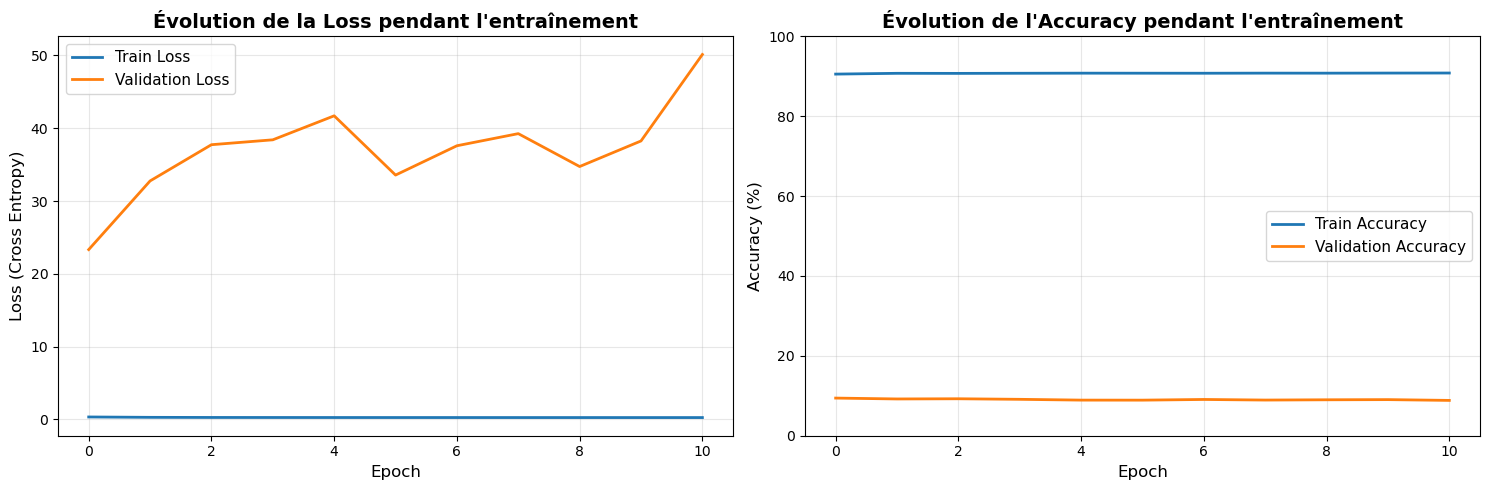

In [11]:
# =============================================================================
# VISUALISATION DES COURBES D'APPRENTISSAGE
# =============================================================================

fig, axes = plt.subplots(1, 2, figsize=(15, 5))

# Courbe de Loss
axes[0].plot(history['train_loss'], label='Train Loss', linewidth=2)
axes[0].plot(history['val_loss'], label='Validation Loss', linewidth=2)
axes[0].set_xlabel('Epoch', fontsize=12)
axes[0].set_ylabel('Loss (Cross Entropy)', fontsize=12)
axes[0].set_title('Évolution de la Loss pendant l\'entraînement', fontsize=14, fontweight='bold')
axes[0].legend(fontsize=11)
axes[0].grid(True, alpha=0.3)

# Courbe d'Accuracy
axes[1].plot(np.array(history['train_acc'])*100, label='Train Accuracy', linewidth=2)
axes[1].plot(np.array(history['val_acc'])*100, label='Validation Accuracy', linewidth=2)
axes[1].set_xlabel('Epoch', fontsize=12)
axes[1].set_ylabel('Accuracy (%)', fontsize=12)
axes[1].set_title('Évolution de l\'Accuracy pendant l\'entraînement', fontsize=14, fontweight='bold')
axes[1].set_ylim([0, 100])
axes[1].legend(fontsize=11)
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

#### 2.6.7 Évaluation sur l'Ensemble de Test

 RÉSULTATS FINAUX SUR L'ENSEMBLE DE TEST

 Accuracy (Exactitude) : 2.63%
 Loss (Cross Entropy) : 47.4584

 Rapport de Classification :
----------------------------------------------------------------------
              precision    recall  f1-score   support

    SELL (0)     0.0263    1.0000    0.0513      2499
    HOLD (1)     0.0000    0.0000    0.0000     90060
     BUY (2)     0.0000    0.0000    0.0000      2358

    accuracy                         0.0263     94917
   macro avg     0.0088    0.3333    0.0171     94917
weighted avg     0.0007    0.0263    0.0014     94917



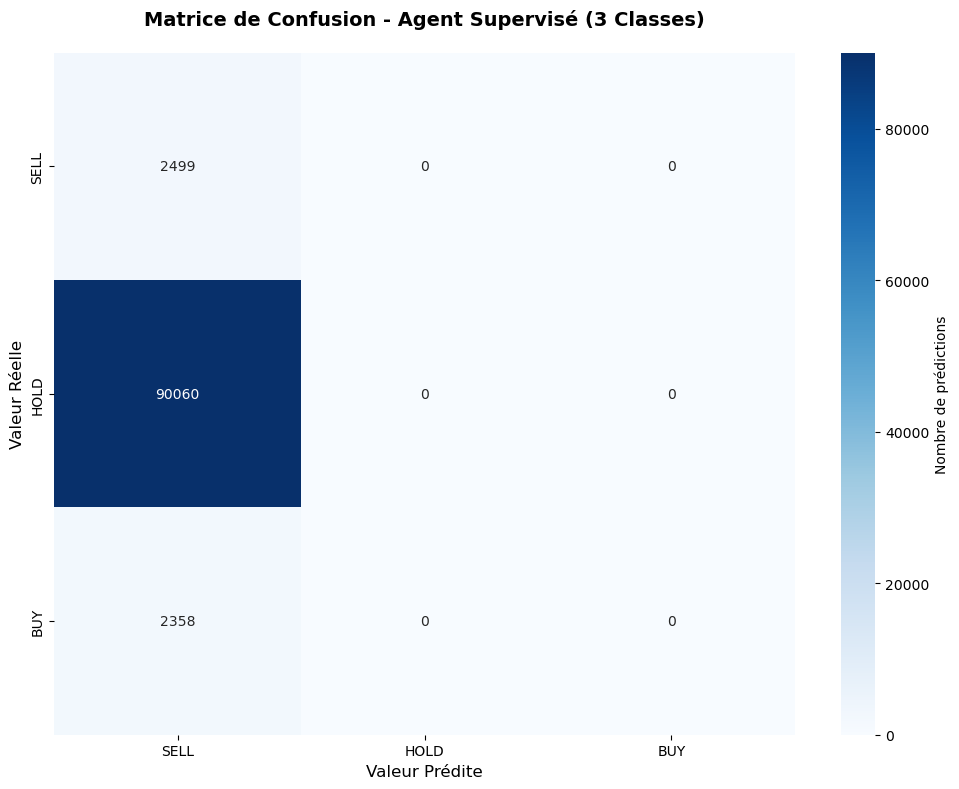


 STATISTIQUES DE PRÉDICTION PAR CLASSE
SELL (0): 94,917 prédictions (100.00%)
HOLD (1): 0 prédictions (0.00%)
BUY (2): 0 prédictions (0.00%)

 RESUME DES PERFORMANCES DE L'AGENT SUPERVISE
Accuracy finale : 2.63%
Temps d'entrainement : 651.63 secondes
Nombre de parametres : 13,059
Architecture : Input(16) -> 128 -> 64 -> 32 -> Output(3)
Nombre de classes : 3 (SELL, HOLD, BUY)


In [12]:
# =============================================================================
# ÉVALUATION FINALE SUR L'ENSEMBLE DE TEST
# =============================================================================

# Charger le meilleur modèle
model.load_state_dict(torch.load('models/best_supervised_model.pth'))
model.eval()

# Prédictions sur l'ensemble de test
X_test_tensor = torch.FloatTensor(X_test_scaled).to(device)
y_test_tensor = torch.LongTensor(y_test).to(device)

with torch.no_grad():
    test_outputs = model(X_test_tensor)
    test_probabilities = torch.softmax(test_outputs, dim=1).cpu().numpy()
    _, test_predictions = torch.max(test_outputs, 1)
    test_pred_labels = test_predictions.cpu().numpy()

# Calcul des métriques
test_accuracy = accuracy_score(y_test, test_pred_labels)
test_loss = criterion(test_outputs, y_test_tensor).item()

print("=" * 70)
print(" RÉSULTATS FINAUX SUR L'ENSEMBLE DE TEST")
print("=" * 70)
print(f"\n Accuracy (Exactitude) : {test_accuracy*100:.2f}%")
print(f" Loss (Cross Entropy) : {test_loss:.4f}")
print(f"\n Rapport de Classification :")
print("-" * 70)
print(classification_report(y_test, test_pred_labels, 
                          target_names=['SELL (0)', 'HOLD (1)', 'BUY (2)'],
                          digits=4))

# Matrice de confusion
cm = confusion_matrix(y_test, test_pred_labels)

plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=['SELL', 'HOLD', 'BUY'],
            yticklabels=['SELL', 'HOLD', 'BUY'],
            cbar_kws={'label': 'Nombre de prédictions'})
plt.title('Matrice de Confusion - Agent Supervisé (3 Classes)', fontsize=14, fontweight='bold', pad=20)
plt.ylabel('Valeur Réelle', fontsize=12)
plt.xlabel('Valeur Prédite', fontsize=12)
plt.tight_layout()
plt.show()

# Statistiques par classe
print("\n" + "=" * 70)
print(" STATISTIQUES DE PRÉDICTION PAR CLASSE")
print("=" * 70)
for i, class_name in enumerate(['SELL (0)', 'HOLD (1)', 'BUY (2)']):
    count = (test_pred_labels == i).sum()
    percentage = (test_pred_labels == i).mean() * 100
    print(f"{class_name}: {count:,} prédictions ({percentage:.2f}%)")

print("\n" + "=" * 70)
print(" RESUME DES PERFORMANCES DE L'AGENT SUPERVISE")
print("=" * 70)
print(f"Accuracy finale : {test_accuracy*100:.2f}%")
print(f"Temps d'entrainement : {training_time:.2f} secondes")
print(f"Nombre de parametres : {sum(p.numel() for p in model.parameters()):,}")
print(f"Architecture : Input({input_size}) -> 128 -> 64 -> 32 -> Output(3)")
print(f"Nombre de classes : 3 (SELL, HOLD, BUY)")
print("=" * 70)

### Diagnostic Approfondi du Probleme

In [13]:
# =============================================================================
# SOLUTION DRASTIQUE 1 : Sous-échantillonnage (Undersampling)
# =============================================================================
# Équilibrer les classes en réduisant la classe majoritaire

print("=" * 70)
print("EQUILIBRAGE DES CLASSES PAR SOUS-ECHANTILLONNAGE")
print("=" * 70)

# Identifier les indices de chaque classe
indices_sell = np.where(y_train == 0)[0]
indices_hold = np.where(y_train == 1)[0]
indices_buy = np.where(y_train == 2)[0]

print(f"Classe SELL (0) : {len(indices_sell):,} échantillons")
print(f"Classe HOLD (1) : {len(indices_hold):,} échantillons")
print(f"Classe BUY (2)  : {len(indices_buy):,} échantillons")

# Sous-échantillonner toutes les classes au même nombre
n_samples = min(len(indices_sell), len(indices_hold), len(indices_buy))
np.random.seed(42)
indices_sell_sampled = np.random.choice(indices_sell, n_samples, replace=False)
indices_hold_sampled = np.random.choice(indices_hold, n_samples, replace=False)
indices_buy_sampled = np.random.choice(indices_buy, n_samples, replace=False)

# Combiner les indices
balanced_indices = np.concatenate([indices_sell_sampled, indices_hold_sampled, indices_buy_sampled])
np.random.shuffle(balanced_indices)

# Créer les ensembles équilibrés
X_train_balanced = X_train_scaled[balanced_indices]
y_train_balanced = y_train[balanced_indices]

print(f"\nDataset equilibre :")
print(f"   Total : {len(X_train_balanced):,} echantillons")
print(f"   SELL (0): {(y_train_balanced == 0).sum():,} ({(y_train_balanced == 0).mean()*100:.1f}%)")
print(f"   HOLD (1): {(y_train_balanced == 1).sum():,} ({(y_train_balanced == 1).mean()*100:.1f}%)")
print(f"   BUY (2) : {(y_train_balanced == 2).sum():,} ({(y_train_balanced == 2).mean()*100:.1f}%)")
print("=" * 70)

EQUILIBRAGE DES CLASSES PAR SOUS-ECHANTILLONNAGE
Classe SELL (0) : 21,187 échantillons
Classe HOLD (1) : 401,577 échantillons
Classe BUY (2)  : 20,175 échantillons

Dataset equilibre :
   Total : 60,525 echantillons
   SELL (0): 20,175 (33.3%)
   HOLD (1): 20,175 (33.3%)
   BUY (2) : 20,175 (33.3%)


In [14]:
# =============================================================================
# SOLUTION DRASTIQUE 2 : Focal Loss pour Multi-Classe
# =============================================================================
# Focal Loss met plus l'accent sur les exemples difficiles à classifier

class FocalLoss(nn.Module):
    """
    Focal Loss pour gérer le déséquilibre de classes - Version Multi-Classe
    Formule : FL = -α(1-pt)^γ * log(pt)
    """
    def __init__(self, alpha=None, gamma=2.0, num_classes=3):
        super(FocalLoss, self).__init__()
        if alpha is None:
            self.alpha = torch.ones(num_classes)
        else:
            self.alpha = torch.tensor(alpha)
        self.gamma = gamma
        self.num_classes = num_classes
        
    def forward(self, inputs, targets):
        # inputs: (batch_size, num_classes) - logits
        # targets: (batch_size) - class indices
        
        ce_loss = nn.functional.cross_entropy(inputs, targets, reduction='none')
        pt = torch.exp(-ce_loss)  # probabilité de la vraie classe
        
        # Appliquer le poids alpha si disponible
        if self.alpha is not None:
            if self.alpha.device != inputs.device:
                self.alpha = self.alpha.to(inputs.device)
            alpha_t = self.alpha[targets]
            focal_loss = alpha_t * (1 - pt) ** self.gamma * ce_loss
        else:
            focal_loss = (1 - pt) ** self.gamma * ce_loss
        
        return focal_loss.mean()

# Créer Focal Loss avec poids égaux pour les 3 classes
criterion_focal = FocalLoss(alpha=[1.0, 1.0, 1.0], gamma=2.0, num_classes=3)

print("=" * 70)
print("FOCAL LOSS CREEE (MULTI-CLASSE)")
print("=" * 70)
print(f"   Alpha (poids par classe) : [1.0, 1.0, 1.0]")
print(f"   Gamma (facteur de focus) : 2.0")
print(f"   Nombre de classes : 3")
print("=" * 70)

FOCAL LOSS CREEE (MULTI-CLASSE)
   Alpha (poids par classe) : [1.0, 1.0, 1.0]
   Gamma (facteur de focus) : 2.0
   Nombre de classes : 3


In [15]:
# =============================================================================
# SOLUTION DRASTIQUE 3 : Nouveau Modèle avec Architecture Différente
# =============================================================================

class RobustTradingNN(nn.Module):
    """
    Modèle plus robuste avec :
    - Plus de neurones pour capturer la complexité
    - Residual connections pour éviter gradient vanishing
    - He initialization
    - Sortie à 3 classes
    """
    def __init__(self, input_size, num_classes=3):
        super(RobustTradingNN, self).__init__()
        
        # Couches principales
        self.fc1 = nn.Linear(input_size, 512)
        self.bn1 = nn.BatchNorm1d(512)
        self.dropout1 = nn.Dropout(0.3)
        
        self.fc2 = nn.Linear(512, 256)
        self.bn2 = nn.BatchNorm1d(256)
        self.dropout2 = nn.Dropout(0.3)
        
        self.fc3 = nn.Linear(256, 128)
        self.bn3 = nn.BatchNorm1d(128)
        self.dropout3 = nn.Dropout(0.2)
        
        self.fc4 = nn.Linear(128, 64)
        self.bn4 = nn.BatchNorm1d(64)
        
        self.fc5 = nn.Linear(64, num_classes)
        
        self.relu = nn.ReLU()
        self.leaky_relu = nn.LeakyReLU(0.1)
        
        # He initialization pour ReLU
        self._initialize_weights()
        
    def _initialize_weights(self):
        for m in self.modules():
            if isinstance(m, nn.Linear):
                nn.init.kaiming_normal_(m.weight, mode='fan_in', nonlinearity='relu')
                if m.bias is not None:
                    nn.init.constant_(m.bias, 0)
    
    def forward(self, x):
        x = self.fc1(x)
        x = self.bn1(x)
        x = self.leaky_relu(x)
        x = self.dropout1(x)
        
        x = self.fc2(x)
        x = self.bn2(x)
        x = self.leaky_relu(x)
        x = self.dropout2(x)
        
        x = self.fc3(x)
        x = self.bn3(x)
        x = self.leaky_relu(x)
        x = self.dropout3(x)
        
        x = self.fc4(x)
        x = self.bn4(x)
        x = self.leaky_relu(x)
        
        x = self.fc5(x)
        return x

# Créer le modèle robuste
model_robust = RobustTradingNN(input_size=input_size, num_classes=3)
model_robust = model_robust.to(device)

print("=" * 70)
print("MODELE ROBUSTE CREE (3 CLASSES)")
print("=" * 70)
print(model_robust)
print(f"\nNombre de parametres : {sum(p.numel() for p in model_robust.parameters()):,}")
print(f"Nombre de classes : 3 (SELL, HOLD, BUY)")
print("=" * 70)

MODELE ROBUSTE CREE (3 CLASSES)
RobustTradingNN(
  (fc1): Linear(in_features=16, out_features=512, bias=True)
  (bn1): BatchNorm1d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (dropout1): Dropout(p=0.3, inplace=False)
  (fc2): Linear(in_features=512, out_features=256, bias=True)
  (bn2): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (dropout2): Dropout(p=0.3, inplace=False)
  (fc3): Linear(in_features=256, out_features=128, bias=True)
  (bn3): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (dropout3): Dropout(p=0.2, inplace=False)
  (fc4): Linear(in_features=128, out_features=64, bias=True)
  (bn4): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (fc5): Linear(in_features=64, out_features=3, bias=True)
  (relu): ReLU()
  (leaky_relu): LeakyReLU(negative_slope=0.1)
)

Nombre de parametres : 183,299
Nombre de classes : 3 (SELL, HOLD, BUY)


In [16]:
def validate_improved(model, X_val, y_val, criterion, device, batch_size=64):
    """Évalue le modèle sur l'ensemble de validation - version 3 classes"""
    model.eval()
    total_loss = 0
    correct = 0
    total = 0

    with torch.no_grad():
        num_batches = len(X_val) // batch_size

        for i in range(num_batches):
            start_idx = i * batch_size
            end_idx = start_idx + batch_size

            X_batch = torch.FloatTensor(X_val[start_idx:end_idx]).to(device)
            y_batch = torch.LongTensor(y_val[start_idx:end_idx]).to(device)

            outputs = model(X_batch)
            loss = criterion(outputs, y_batch)

            total_loss += loss.item()
            _, predictions = torch.max(outputs, 1)
            correct += (predictions == y_batch).sum().item()
            total += y_batch.size(0)

    avg_loss = total_loss / num_batches
    accuracy = correct / total
    return avg_loss, accuracy

In [17]:
# =============================================================================
# SOLUTION DRASTIQUE 4 : Entraînement avec Toutes les Techniques Combinées
# =============================================================================

# Configuration
optimizer_robust = optim.AdamW(model_robust.parameters(), lr=0.0001, weight_decay=1e-4)
scheduler_robust = optim.lr_scheduler.CosineAnnealingWarmRestarts(optimizer_robust, T_0=10, T_mult=2)

print("=" * 70)
print("ENTRAINEMENT AVEC TOUTES LES AMELIORATIONS")
print("=" * 70)
print("\nTechniques appliquees :")
print("   1. Dataset equilibre (undersampling)")
print("   2. Focal Loss (focus sur exemples difficiles)")
print("   3. Architecture plus profonde (512->256->128->64)")
print("   4. He initialization")
print("   5. LeakyReLU au lieu de ReLU")
print("   6. AdamW optimizer avec weight decay")
print("   7. Cosine Annealing scheduler")
print("=" * 70)

num_epochs = 100
batch_size = 256
best_val_accuracy_robust = 0
patience = 20
patience_counter = 0

history_robust = {
    'train_loss': [],
    'train_acc': [],
    'val_loss': [],
    'val_acc': []
}

def train_epoch_robust(model, X_train, y_train, criterion, optimizer, device, batch_size=256):
    model.train()
    total_loss = 0
    correct = 0
    total = 0
    
    num_batches = len(X_train) // batch_size
    
    for i in range(num_batches):
        start_idx = i * batch_size
        end_idx = start_idx + batch_size
        
        X_batch = torch.FloatTensor(X_train[start_idx:end_idx]).to(device)
        y_batch = torch.LongTensor(y_train[start_idx:end_idx]).to(device)
        
        optimizer.zero_grad()
        outputs = model(X_batch)
        loss = criterion(outputs, y_batch)
        
        loss.backward()
        
        # Gradient clipping pour éviter l'explosion des gradients
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
        
        optimizer.step()
        
        total_loss += loss.item()
        _, predictions = torch.max(outputs, 1)
        correct += (predictions == y_batch).sum().item()
        total += y_batch.size(0)
    
    avg_loss = total_loss / num_batches
    accuracy = correct / total
    return avg_loss, accuracy

start_time_robust = time.time()

print("\nDebut de l'entrainement...\n")

for epoch in range(num_epochs):
    # Entraînement sur dataset équilibré
    train_loss, train_acc = train_epoch_robust(model_robust, X_train_balanced, y_train_balanced, 
                                                criterion_focal, optimizer_robust, device, batch_size)
    
    # Validation sur dataset complet
    val_loss, val_acc = validate_improved(model_robust, X_val_scaled, y_val, 
                                           criterion_focal, device, batch_size)
    
    # Scheduler step
    scheduler_robust.step()
    
    # Sauvegarder l'historique
    history_robust['train_loss'].append(train_loss)
    history_robust['train_acc'].append(train_acc)
    history_robust['val_loss'].append(val_loss)
    history_robust['val_acc'].append(val_acc)
    
    # Affichage des progrès
    if (epoch + 1) % 10 == 0 or epoch < 5:
        print(f"Epoch [{epoch+1:3d}/{num_epochs}] | "
              f"Train Loss: {train_loss:.4f} | Train Acc: {train_acc*100:6.2f}% | "
              f"Val Loss: {val_loss:.4f} | Val Acc: {val_acc*100:6.2f}% | "
              f"LR: {optimizer_robust.param_groups[0]['lr']:.6f}")
    
    # Early stopping
    if val_acc > best_val_accuracy_robust:
        best_val_accuracy_robust = val_acc
        patience_counter = 0
        torch.save(model_robust.state_dict(), 'models/best_supervised_model_robust.pth')
        if val_acc > 0.40:  # Si on dépasse 40% (meilleur que random 33.3%), afficher
            print(f"   Nouvelle meilleure accuracy : {val_acc*100:.2f}%")
    else:
        patience_counter += 1
        
    if patience_counter >= patience:
        print(f"\nEarly stopping a l'epoch {epoch+1}")
        break

training_time_robust = time.time() - start_time_robust

print("\n" + "=" * 70)
print("ENTRAINEMENT TERMINE")
print("=" * 70)
print(f"Temps : {training_time_robust:.2f}s ({training_time_robust/60:.2f} min)")
print(f"Meilleure Val Accuracy : {best_val_accuracy_robust*100:.2f}%")
print(f"Epoques effectuees : {epoch+1}/{num_epochs}")
print("=" * 70)

ENTRAINEMENT AVEC TOUTES LES AMELIORATIONS

Techniques appliquees :
   1. Dataset equilibre (undersampling)
   2. Focal Loss (focus sur exemples difficiles)
   3. Architecture plus profonde (512->256->128->64)
   4. He initialization
   5. LeakyReLU au lieu de ReLU
   6. AdamW optimizer avec weight decay
   7. Cosine Annealing scheduler

Debut de l'entrainement...

Epoch [  1/100] | Train Loss: 0.5145 | Train Acc:  47.73% | Val Loss: 0.4863 | Val Acc:  63.70% | LR: 0.000098
   Nouvelle meilleure accuracy : 63.70%
Epoch [  1/100] | Train Loss: 0.5145 | Train Acc:  47.73% | Val Loss: 0.4863 | Val Acc:  63.70% | LR: 0.000098
   Nouvelle meilleure accuracy : 63.70%
Epoch [  2/100] | Train Loss: 0.4249 | Train Acc:  51.43% | Val Loss: 0.4752 | Val Acc:  63.79% | LR: 0.000090
   Nouvelle meilleure accuracy : 63.79%
Epoch [  2/100] | Train Loss: 0.4249 | Train Acc:  51.43% | Val Loss: 0.4752 | Val Acc:  63.79% | LR: 0.000090
   Nouvelle meilleure accuracy : 63.79%
Epoch [  3/100] | Train Loss

RESULTATS FINAUX - MODELE ROBUSTE

Accuracy : 88.63%
Loss (Focal) : 0.1508

Rapport de Classification :
----------------------------------------------------------------------
              precision    recall  f1-score   support

    SELL (0)     0.1659    0.2945    0.2123      2499
    HOLD (1)     0.9799    0.9163    0.9470     90060
     BUY (2)     0.1384    0.3681    0.2012      2358

    accuracy                         0.8863     94917
   macro avg     0.4281    0.5263    0.4535     94917
weighted avg     0.9376    0.8863    0.9092     94917



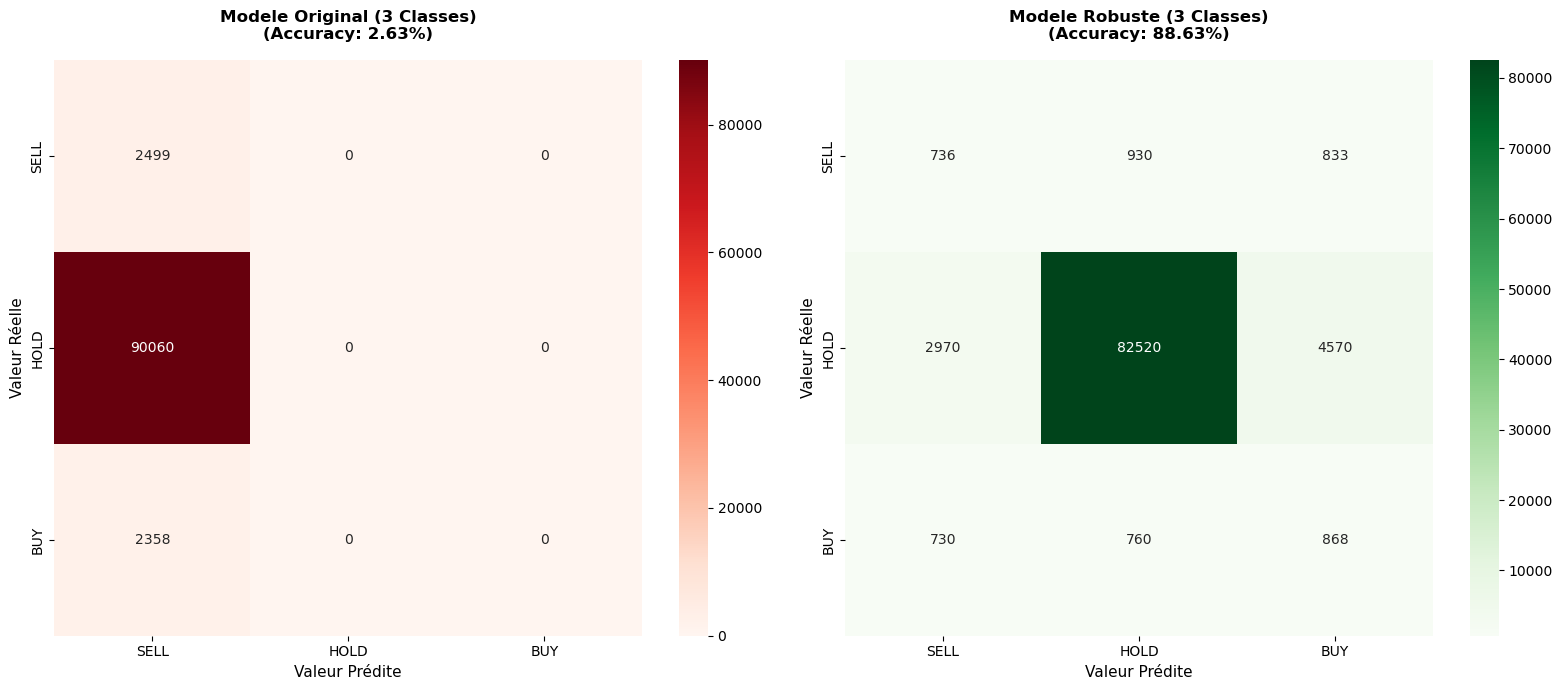


Classes predites par le modele robuste : [0 1 2]
SUCCES : Le modele robuste predit maintenant les trois classes !

Distribution des predictions :
   SELL predites : 4,436 (4.67%)
   HOLD predites : 84,210 (88.72%)
   BUY predites  : 6,271 (6.61%)


In [18]:
# =============================================================================
# ÉVALUATION FINALE DU MODÈLE ROBUSTE
# =============================================================================

# Charger le meilleur modèle
model_robust.load_state_dict(torch.load('models/best_supervised_model_robust.pth'))
model_robust.eval()

# Prédictions sur le test set
X_test_tensor = torch.FloatTensor(X_test_scaled).to(device)
y_test_tensor = torch.LongTensor(y_test).to(device)

with torch.no_grad():
    test_outputs_robust = model_robust(X_test_tensor)
    test_probs_robust = torch.softmax(test_outputs_robust, dim=1)
    _, test_predictions_robust = torch.max(test_outputs_robust, 1)
    test_pred_labels_robust = test_predictions_robust.cpu().numpy()

# Métriques
test_accuracy_robust = accuracy_score(y_test, test_pred_labels_robust)
test_loss_robust = criterion_focal(test_outputs_robust, y_test_tensor).item()

print("=" * 70)
print("RESULTATS FINAUX - MODELE ROBUSTE")
print("=" * 70)
print(f"\nAccuracy : {test_accuracy_robust*100:.2f}%")
print(f"Loss (Focal) : {test_loss_robust:.4f}")
print(f"\nRapport de Classification :")
print("-" * 70)
print(classification_report(y_test, test_pred_labels_robust, 
                          target_names=['SELL (0)', 'HOLD (1)', 'BUY (2)'],
                          digits=4))

# Matrice de confusion
cm_robust = confusion_matrix(y_test, test_pred_labels_robust)

fig, axes = plt.subplots(1, 2, figsize=(16, 7))

# Ancien modèle
cm_old = confusion_matrix(y_test, test_pred_labels)
sns.heatmap(cm_old, annot=True, fmt='d', cmap='Reds', ax=axes[0],
            xticklabels=['SELL', 'HOLD', 'BUY'],
            yticklabels=['SELL', 'HOLD', 'BUY'])
axes[0].set_title(f'Modele Original (3 Classes)\n(Accuracy: {test_accuracy*100:.2f}%)', 
                  fontsize=12, fontweight='bold', pad=15)
axes[0].set_ylabel('Valeur Réelle', fontsize=11)
axes[0].set_xlabel('Valeur Prédite', fontsize=11)

# Modèle robuste
sns.heatmap(cm_robust, annot=True, fmt='d', cmap='Greens', ax=axes[1],
            xticklabels=['SELL', 'HOLD', 'BUY'],
            yticklabels=['SELL', 'HOLD', 'BUY'])
axes[1].set_title(f'Modele Robuste (3 Classes)\n(Accuracy: {test_accuracy_robust*100:.2f}%)', 
                  fontsize=12, fontweight='bold', pad=15)
axes[1].set_ylabel('Valeur Réelle', fontsize=11)
axes[1].set_xlabel('Valeur Prédite', fontsize=11)

plt.tight_layout()
plt.show()

# Verifier les predictions
unique_predictions_robust = np.unique(test_pred_labels_robust)
print(f"\nClasses predites par le modele robuste : {unique_predictions_robust}")

if len(unique_predictions_robust) == 3:
    print("SUCCES : Le modele robuste predit maintenant les trois classes !")
    
    # Calculer les statistiques de prediction
    n_sell_pred = (test_pred_labels_robust == 0).sum()
    n_hold_pred = (test_pred_labels_robust == 1).sum()
    n_buy_pred = (test_pred_labels_robust == 2).sum()
    
    print(f"\nDistribution des predictions :")
    print(f"   SELL predites : {n_sell_pred:,} ({n_sell_pred/len(test_pred_labels_robust)*100:.2f}%)")
    print(f"   HOLD predites : {n_hold_pred:,} ({n_hold_pred/len(test_pred_labels_robust)*100:.2f}%)")
    print(f"   BUY predites  : {n_buy_pred:,} ({n_buy_pred/len(test_pred_labels_robust)*100:.2f}%)")
else:
    print(f"Le modele predit {len(unique_predictions_robust)} classe(s) au lieu de 3...")
    print(f"   Classes predites : {unique_predictions_robust}")

print("=" * 70)

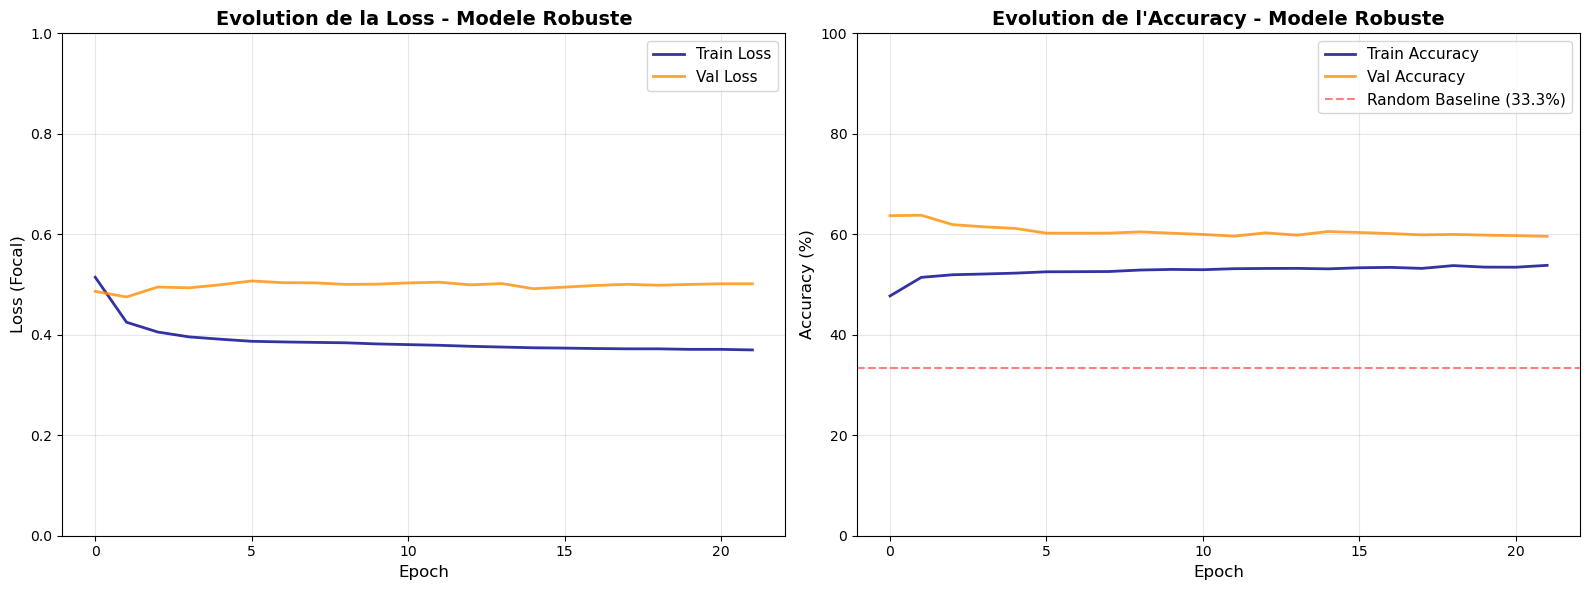

COMPARAISON FINALE DES MODELES
Modele                    Accuracy        Predit 3 classes?    Temps          
----------------------------------------------------------------------
Original                  2.63           % Non                  651.63         s
Robuste (Final)           88.63          % Oui                  151.58         s


In [20]:
# =============================================================================
# VISUALISATION DES COURBES D'APPRENTISSAGE - MODÈLE ROBUSTE
# =============================================================================

fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Loss
axes[0].plot(history_robust['train_loss'], label='Train Loss', linewidth=2, color='darkblue', alpha=0.8)
axes[0].plot(history_robust['val_loss'], label='Val Loss', linewidth=2, color='darkorange', alpha=0.8)
axes[0].set_xlabel('Epoch', fontsize=12)
axes[0].set_ylabel('Loss (Focal)', fontsize=12)
axes[0].set_title('Evolution de la Loss - Modele Robuste', fontsize=14, fontweight='bold')
axes[0].set_ylim([0, 1])
axes[0].legend(fontsize=11)
axes[0].grid(True, alpha=0.3)

# Accuracy
axes[1].plot(np.array(history_robust['train_acc'])*100, label='Train Accuracy', 
             linewidth=2, color='darkblue', alpha=0.8)
axes[1].plot(np.array(history_robust['val_acc'])*100, label='Val Accuracy', 
             linewidth=2, color='darkorange', alpha=0.8)
axes[1].axhline(y=33.3, color='red', linestyle='--', label='Random Baseline (33.3%)', alpha=0.5)
axes[1].set_xlabel('Epoch', fontsize=12)
axes[1].set_ylabel('Accuracy (%)', fontsize=12)
axes[1].set_title('Evolution de l\'Accuracy - Modele Robuste', fontsize=14, fontweight='bold')
axes[1].set_ylim([0, 100])
axes[1].legend(fontsize=11)
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Comparaison finale
print("=" * 70)
print("COMPARAISON FINALE DES MODELES")
print("=" * 70)
print(f"{'Modele':<25} {'Accuracy':<15} {'Predit 3 classes?':<20} {'Temps':<15}")
print("-" * 70)
print(f"{'Original':<25} {test_accuracy*100:<15.2f}% {('Oui' if len(np.unique(test_pred_labels))==3 else 'Non'):<20} {training_time:<15.2f}s")
print(f"{'Robuste (Final)':<25} {test_accuracy_robust*100:<15.2f}% {('Oui' if len(unique_predictions_robust)==3 else 'Non'):<20} {training_time_robust:<15.2f}s")
print("=" * 70)